In [10]:
# ================================
# Cell 1: Setup & Libraries
# ================================

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import statsmodels.api as sm

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Config
warnings.filterwarnings("ignore")
plt.style.use("ggplot")
pd.set_option("display.max_columns", None)

# Download VADER (run once)
nltk.download("vader_lexicon")

print("✅ Environment & libraries ready.")


✅ Environment & libraries ready.


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
# ================================
# Cell 2: Load & Clean Data
# ================================

print("📦 Loading dataset...")
df = pd.read_csv("/content/amazon.csv")

# ---- Column Mapping (EDIT IF NEEDED) ----
column_mapping = {
    "product_id": "Product_ID",
    "product_name": "Product_Name",
    "category": "Category",
    "discounted_price": "Price",
    "actual_price": "Old_Price",
    "rating": "Star_Rating",
    "rating_count": "Sales_Volume",
    "review_content": "Review_Text"
}

df.rename(columns=column_mapping, inplace=True)
print("Columns found:", df.columns.tolist())

# ---- Cleaning Functions ----
def clean_currency(x):
    if isinstance(x, str):
        x = (
            x.replace("₹", "")
             .replace("$", "")
             .replace(",", "")
             .strip()
        )
        try:
            return float(x)
        except:
            return np.nan
    return x

def clean_rating(x):
    if isinstance(x, str):
        try:
            return float(x.replace("|", "").strip())
        except:
            return np.nan
    return x

# ---- Apply Cleaning ----
for col in ["Price", "Old_Price", "Sales_Volume"]:
    if col in df.columns:
        df[col] = df[col].apply(clean_currency)

if "Star_Rating" in df.columns:
    df["Star_Rating"] = df["Star_Rating"].apply(clean_rating)

# ---- Drop Critical Missing Values ----
df.dropna(subset=["Price", "Star_Rating", "Review_Text"], inplace=True)

# ---- Discount Percentage ----
if "Old_Price" in df.columns:
    df["discount_percentage"] = (df["Old_Price"] - df["Price"]) / df["Old_Price"]
else:
    df["discount_percentage"] = 0.0

print(f"✅ Data cleaned: {df.shape[0]} rows remaining")
df.head(3)


📦 Loading dataset...
Columns found: ['Product_ID', 'Product_Name', 'Category', 'Price', 'Old_Price', 'discount_percentage', 'Star_Rating', 'Sales_Volume', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'Review_Text', 'img_link', 'product_link']
✅ Data cleaned: 1464 rows remaining


,Product_ID,Product_Name,Category,Price,Old_Price,discount_percentage,Star_Rating,Sales_Volume,about_product,user_id,user_name,review_id,review_title,Review_Text,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,399.0,1099.0,0.636943,4.2,24269.0,High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,199.0,349.0,0.429799,4.0,43994.0,"Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,199.0,1899.0,0.895208,3.9,7928.0,【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...


In [12]:
# ================================
# Cell 3: Sentiment Analysis
# ================================

print("🧠 Running sentiment analysis...")
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    if not isinstance(text, str):
        return 0.0
    return analyzer.polarity_scores(text)["compound"]

df["Sentiment_Score"] = df["Review_Text"].apply(get_sentiment)

# ---- Detect Rating Inflation ----
df["Rating_Inflation"] = (
    (df["Star_Rating"] >= 4) & (df["Sentiment_Score"] < -0.05)
).astype(int)

flagged = df[df["Rating_Inflation"] == 1]
print(f"⚠️ Rating inflation detected in {len(flagged)} products")

if not flagged.empty:
    sample = flagged.iloc[0]
    print("Example:")
    print("Product:", sample["Product_Name"])
    print("Stars:", sample["Star_Rating"])
    print("Sentiment:", sample["Sentiment_Score"])
    print("Review:", sample["Review_Text"][:200], "...")


🧠 Running sentiment analysis...
⚠️ Rating inflation detected in 36 products
Example:
Product: boAt Type C A325 Tangle-free, Sturdy Type C Cable with 3A Rapid Charging & 480mbps Data Transmission(Black)
Stars: 4.1
Sentiment: -0.1887
Review: Check for offera before buying,18w charging cable,,Awesome cable!Charging, data transfer and durability is simply awesome, and there is not a single disconnection issue, which I always faced in origin ...


In [13]:
# ================================
# Cell 4: Price Elasticity
# ================================

print("📉 Calculating price elasticity...")

# Guard against invalid logs
df = df[(df["Price"] > 0) & (df["Sales_Volume"] > 0)]
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

df["log_price"] = np.log(df["Price"])
df["log_sales"] = np.log(df["Sales_Volume"])

results = []

for category in df["Category"].unique():
    subset = df[df["Category"] == category]

    if len(subset) < 5:
        continue

    X = sm.add_constant(subset["log_price"])
    y = subset["log_sales"]

    model = sm.OLS(y, X).fit()

    if model.pvalues["log_price"] < 0.05:
        elasticity = model.params["log_price"]
        r2 = model.rsquared
    else:
        elasticity = np.nan
        r2 = np.nan

    results.append({
        "Category": category,
        "Elasticity": elasticity,
        "R_Squared": r2,
        "Avg_Sentiment": subset["Sentiment_Score"].mean()
    })

elasticity_df = pd.DataFrame(results)
print("✅ Elasticity calculated")
elasticity_df.head()


📉 Calculating price elasticity...
✅ Elasticity calculated


,Category,Elasticity,R_Squared,Avg_Sentiment
0,Computers&Accessories|Accessories&Peripherals|...,NaN,NaN,0.847781
1,Computers&Accessories|NetworkingDevices|Networ...,1.536985,0.361389,0.941461
2,"Electronics|HomeTheater,TV&Video|Accessories|C...",NaN,NaN,0.807067
3,"Electronics|HomeTheater,TV&Video|Televisions|S...",NaN,NaN,0.808510
4,"Electronics|HomeTheater,TV&Video|Accessories|R...",-0.930222,0.187729,0.634280


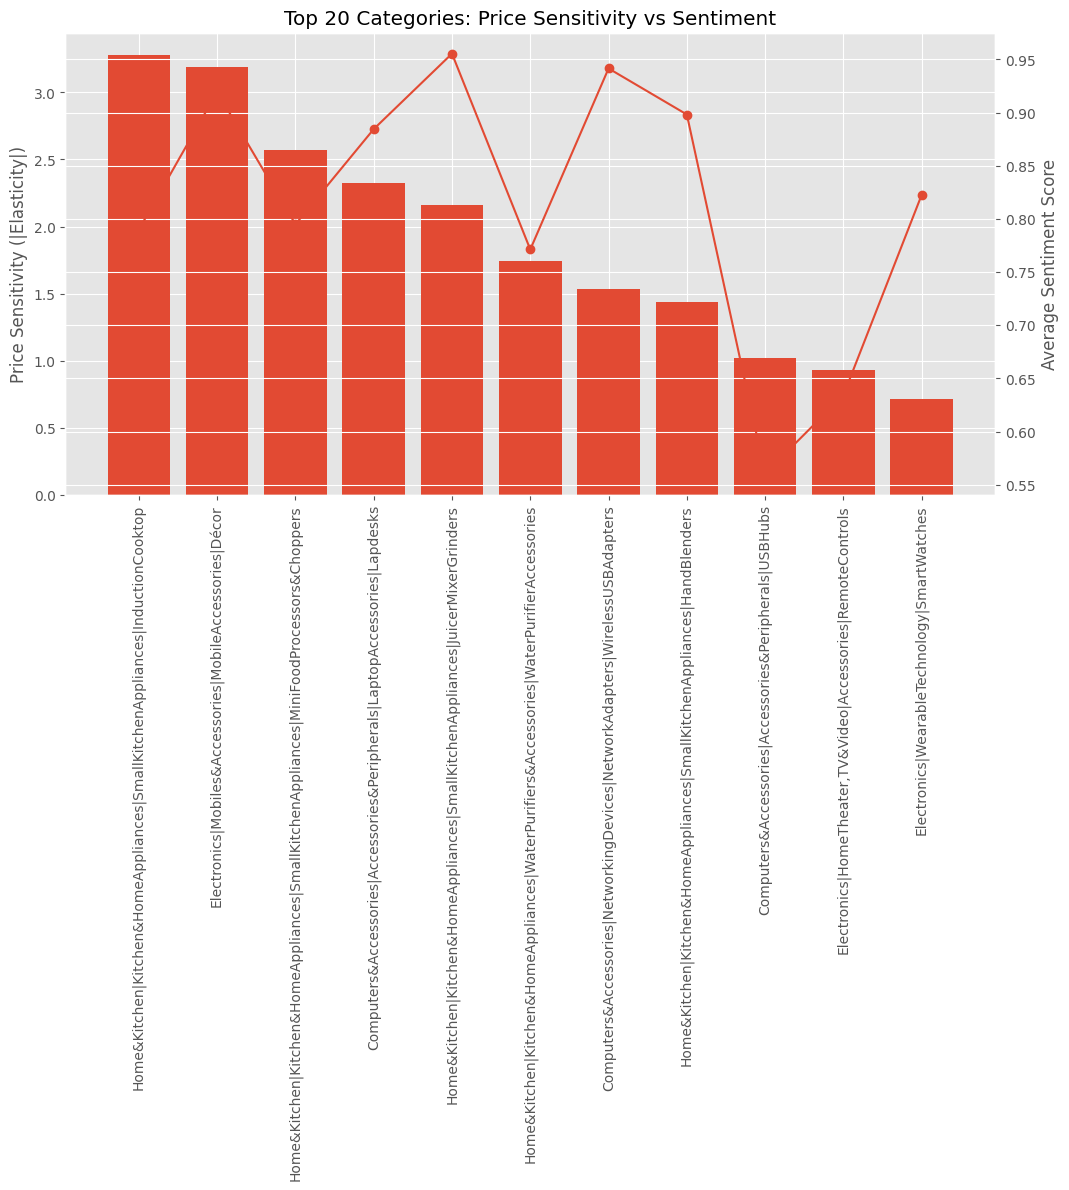

📊 Chart saved to images/elasticity_chart.png


In [14]:
# ================================
# Cell 5: Visualization
# ================================

top = (
    elasticity_df
    .dropna()
    .assign(abs_elasticity=lambda x: x["Elasticity"].abs())
    .sort_values("abs_elasticity", ascending=False)
    .head(20)
)

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(top["Category"], top["abs_elasticity"])
ax1.set_ylabel("Price Sensitivity (|Elasticity|)")
ax1.set_xticklabels(top["Category"], rotation=90)

ax2 = ax1.twinx()
ax2.plot(top["Category"], top["Avg_Sentiment"], marker="o")
ax2.set_ylabel("Average Sentiment Score")

plt.title("Top 20 Categories: Price Sensitivity vs Sentiment")
plt.tight_layout()

os.makedirs("images", exist_ok=True)
plt.savefig("images/elasticity_chart.png")
plt.show()

print("📊 Chart saved to images/elasticity_chart.png")


In [15]:
# ================================
# Cell 6: Save Results
# ================================

os.makedirs("data", exist_ok=True)

df.to_csv("data/amazon_processed_with_sentiment.csv", index=False)
elasticity_df.to_csv("data/category_elasticity_summary.csv", index=False)

print("💾 Files saved:")
print("- data/amazon_processed_with_sentiment.csv")
print("- data/category_elasticity_summary.csv")


💾 Files saved:
- data/amazon_processed_with_sentiment.csv
- data/category_elasticity_summary.csv
